# Traitement des données

Dans cette partie, l'objectif est d'importer nos données, les convertir à un format convenable pour la production de statistiques descriptives, et exporter le résultat pour que ces bases puissent être utilisées par les autres programmes

Les bases en question sont :
- la base listant tous les incidents de violence par armes à feu aux USA entre 2013 et 2018
- la base listant les caractéristiques économiques générales des comtés et de ses habitants.
- la base gun_legislation proposant une synthèse des différences de législation entre Etats
- la base bg_checks recensant tous les *background checks* du FBI pour l'année 2018 (documentation fournie plus bas)

In [113]:
#Pour le traitement classique
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon
from tqdm import tqdm

#Pour l'interaction avec l'API 
import requests
from statistics import mean
import time

## Traitement de la base d'incidents armes à feu

In [114]:
#Base incidents armes à feu
url="https://drive.google.com/file/d/1GGOLMc_Ow9yZC9sICegPegDggQuHOD3t/view?usp=drive_link"
url="https://drive.google.com/uc?export=download&confirm=1&id=" + url.split("/")[-2]
gun_violence_db = pd.read_csv(url)
gun_violence_db.sample(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
135576,606311,2016-07-15,Oklahoma,Oklahoma City,4215 S.E. 53rd Street,0,1,http://www.gunviolencearchive.org/incident/606311,http://www.news9.com/story/32454125/police-inv...,False,...,NaN,NaN,NaN,NaN,NaN,0::Injured,0::Victim,http://www.news9.com/story/32454125/police-inv...,94.0,45.0
184960,1059529,2017-05-01,Illinois,Rockford,2000 School St,0,0,http://www.gunviolencearchive.org/incident/105...,http://www.rrstar.com/news/20180228/rockford-m...,False,...,0::34,0::Adult 18+,0::Male,0::Jeremy J McCristal,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,http://www.rrstar.com/news/20180228/rockford-m...,67.0,34.0
6093,106763,2014-02-13,Tennessee,Memphis,4950 Fairley Road,0,0,http://www.gunviolencearchive.org/incident/106763,http://www.wmctv.com/story/24720610/scso-gun-m...,False,...,0::18,0::Adult 18+,0::Male,0::Curtis Walton,NaN,0::Unharmed,0::Subject-Suspect,http://www.wmctv.com/story/24720610/scso-gun-m...,85.0,29.0
187694,845094,2017-05-16,Ohio,Cincinnati,3406 Warsaw Ave,0,1,http://www.gunviolencearchive.org/incident/845094,http://local12.com/news/local/shooting-in-east...,False,...,NaN,0::Adult 18+||1::Adult 18+,0::Male||1::Male,NaN,NaN,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,http://local12.com/news/local/shooting-in-east...,29.0,8.0
218914,989516,2017-11-16,Tennessee,Smyrna,291 Sam Ridley Pkwy,0,0,http://www.gunviolencearchive.org/incident/989516,http://www.wsmv.com/story/36900443/juvenile-ar...,False,...,NaN,0::Teen 12-17,0::Male||1::Male||2::Male||3::Male||4::Female,NaN,NaN,"0::Unharmed, Arrested||1::Unharmed||2::Unharme...",0::Subject-Suspect||1::Subject-Suspect||2::Sub...,http://www.wsmv.com/story/36861739/5-suspects-...,37.0,13.0


Conformément à la documentation de la base, certaines colonnes sont codées de façon à pouvoir les reconvertir en dictionnaire :

In [115]:
def convert_to_dict(value):
    if pd.isna(value):
        return value

    pairs = value.split('||')
    result_dict = {}
    for pair in pairs:
        #Some are corrupted : 1: instead of ::
        if '::' in pair:
            key, val = pair.split('::', 1)
            result_dict[int(key)] = val
        else:
            key, val = pair.split(':', 1)
            result_dict[int(key)] = val
    return result_dict

list_of_dict_columns = ['gun_stolen', 'gun_type', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_name', 'participant_relationship', 'participant_status', 'participant_type']
gun_violence_db[list_of_dict_columns] = gun_violence_db[list_of_dict_columns].applymap(convert_to_dict)
gun_violence_db.head()



/tmp/ipykernel_342865/4075116675.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gun_violence_db[list_of_dict_columns] = gun_violence_db[list_of_dict_columns].applymap(convert_to_dict)


,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,{0: '20'},"{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Male', 1: 'Male', 3: 'Male', 4: 'Female'}",{0: 'Julian Sims'},NaN,"{0: 'Arrested', 1: 'Injured', 2: 'Injured', 3:...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Vi...",http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,{0: '20'},"{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...",{0: 'Male'},{0: 'Bernard Gillis'},NaN,"{0: 'Killed', 1: 'Injured', 2: 'Injured', 3: '...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Vi...",http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,"{0: '25', 1: '31', 2: '33', 3: '34', 4: '33'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Male', 1: 'Male', 2: 'Male', 3: 'Male', 4...","{0: 'Damien Bell', 1: 'Desmen Noble', 2: 'Herm...",NaN,"{0: 'Injured, Unharmed, Arrested', 1: 'Unharme...","{0: 'Subject-Suspect', 1: 'Subject-Suspect', 2...",http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,"{0: '29', 1: '33', 2: '56', 3: '33'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Female', 1: 'Male', 2: 'Male', 3: 'Male'}","{0: 'Stacie Philbrook', 1: 'Christopher Ratlif...",NaN,"{0: 'Killed', 1: 'Killed', 2: 'Killed', 3: 'Ki...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Su...",http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,"{0: '18', 1: '46', 2: '14', 3: '47'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Teen 12-1...","{0: 'Female', 1: 'Male', 2: 'Male', 3: 'Female'}","{0: 'Danielle Imani Jameison', 1: 'Maurice Eug...",{3: 'Family'},"{0: 'Injured', 1: 'Injured', 2: 'Killed', 3: '...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Su...",http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [116]:
gun_violence_db.to_csv("data/gun_violence_db.csv", index=False)

## Traitements des bases comtés de l'API


La documentation précisant le mode d'interaction avec l'API de StLouisFed se trouve à la page https://fred.stlouisfed.org/docs/api/fred/#API.

In [117]:
#Each request is categorized with an url and an id
#The gist here is to recover the proper id to retrieve data
api_key = "180de2e6a1d1e953d270ebf38341cd44"
param = {"api_key" : api_key, "file_type" : "json", "category_id" : "27281"}
url = "https://api.stlouisfed.org/fred/category/children?"

In [118]:
def request_db(index):
    #this function requests to the API the database associated with the category id index
    param["category_id"] = index #on ajuste les paramètres de la request pour demander la bonne catégorie
    response = requests.get(url, params = param)
    data = response.json()
    return data

In [119]:
def check_response(url, param):
    while True:
        response = requests.get(url, params=param).json()

        if not response.get('error_message') or response['error_message'] != 'Too Many Requests.  Exceeded Rate Limit':
            return response
        time.sleep(5)

In [120]:
#Some names are ambiguous between dframes
def simplify_name(name):
    if name.endswith("County"):
        return name.rsplit("County", 1)[0].strip()
    if name.endswith("Parish"):
        return name.rsplit("Parish", 1)[0].strip()
    if name.endswith("Census Area"):
        return name.replace("Census Area", "CA")
    if name.endswith("Borough/city"):
        return name.replace("Borough/city", "Cty&Bor")      
    if name.endswith("Municipality"):
        return name.replace("Municipality", "Muny")
    if name.endswith("Borough/municipality"):
        return name.replace("Borough/municipality", "Muny")    
    if name.endswith("County/city"):
        return name.rsplit("County/city", 1)[0].strip() 

        
    return name

In [121]:
us_data = request_db(27281)['categories']
#We create our dframe by creating a list of dicts, each element is a new row
database = list()
for state in tqdm(us_data):
    id_state = state['id']
    state_name = state['name']
    
    #Request to recover id in order to extract counties
    state_info = request_db(id_state)["categories"]
    if state_info != []: #One exception : which one ?
        id_list_of_state_counties = state_info[0]['id']
        list_of_state_counties = request_db(id_list_of_state_counties)["categories"]
        for county in list_of_state_counties:
            dict_county = dict()
            id_county = county['id']
            
            parts = county['name'].split(', ')
            county_name, state_code = parts[0], parts[-1]
            
            dict_county = {
                'Nom': simplify_name(county_name),
                'Etat': state_name,
                'Code_Etat': state_code,
                'id_Etat': id_state,
                'id_county': id_county
            }
            
            if '+' in county_name:
                county_name, county_bis = county_name.split(' + ')
                dict_county['Nom'] = simplify_name(county_bis)
                database.append(dict_county.copy())  # Append a copy to avoid modifying the original
                dict_county['Nom'] = simplify_name(county_name)
            database.append(dict_county)

counties_db = pd.DataFrame(database)

100%|██████████| 53/53 [00:26<00:00,  1.96it/s]


In [122]:
#Gestion des exceptions pour le merging(obligé de faire du cas par cas car merging sur le code_Etat + nom)

counties_db.loc[(counties_db['Code_Etat'] == 'Aleutian Islands Census Area'), 'Code_Etat'] = 'AK'
counties_db.loc[(counties_db['Code_Etat'] == 'District of Columbia'), 'Code_Etat'] = 'DC'
counties_db.loc[(counties_db['Nom'] == 'De Soto'), 'Nom'] = 'DeSoto'
counties_db.loc[(counties_db['Nom'] == 'DeSoto') & (counties_db['Code_Etat'] == 'LA'), 'Nom'] = 'De Soto'
counties_db.loc[(counties_db['Nom'] == 'De Kalb'), 'Nom'] = 'DeKalb'
counties_db.loc[(counties_db['Nom'] == 'Du Page'), 'Nom'] = 'DuPage'
counties_db.loc[(counties_db['Nom'] == 'La Salle'), 'Nom'] = 'LaSalle'
counties_db.loc[(counties_db['Nom'] == 'La Porte'), 'Nom'] = 'LaPorte'
counties_db.loc[(counties_db['Nom'] == 'Lagrange'), 'Nom'] = 'LaGrange'
counties_db.loc[(counties_db['Nom'] == 'LaFourche'), 'Nom'] = 'Lafourche'
counties_db.loc[(counties_db['Nom'] == 'Lac Qui Parle'), 'Nom'] = 'Lac qui Parle'
counties_db.loc[(counties_db['Nom'] == 'Dona Ana'), 'Nom'] = 'Doña Ana'
counties_db.loc[(counties_db['Nom'] == 'La Moure'), 'Nom'] = 'LaMoure'
counties_db.loc[(counties_db['Nom'] == 'De Witt'), 'Nom'] = 'DeWitt'
counties_db.loc[(counties_db['Nom'] == 'DeWitt') & (counties_db['Code_Etat'] == 'IL'), 'Nom'] = 'De Witt'
counties_db.loc[(counties_db['Nom'] == 'LaSalle') & (counties_db['Code_Etat'] == 'TX'), 'Nom'] = 'La Salle'
counties_db.loc[(counties_db['Code_Etat'] == 'WI (includes Menominee)'), 'Code_Etat'] = 'WI'
counties_db.loc[(counties_db['Nom'] == 'Fond Du Lac'), 'Nom'] = 'Fond du Lac'

On a maintenant un premier dframe recensant tous les comtés des USA ainsi que les ID permettant de les retrouver dans l'API. On peut désormais extraire pour chaque comté les informations socio-démographiques nous permettant de produire nos statistiques descriptives et notre modèle.

Note : id_county fait office de clé primaire dans cette base (au sein de l'API FRED)

In [123]:
counties_db.to_csv("data/counties_db.csv", index=False)

## Récupération des données géographiques par comté

In [124]:
#On change l'URL pour pouvoir récupérer des données géographiques sur tous les comtés (ainsi que le fips, le nom simplifié)
#L'enjeu ici est d'associer les données aux comtés correspondants : les codes id de l'API n'ont pas de correspondance avec les donneés géographiques à part le nom
url = "https://api.stlouisfed.org/geofred/shapes/file?shape=county"

In [125]:
geom_counties_db = request_db(29802)#The code is arbitrary here, each request gives the geometries of all counties
geom_counties_db = gpd.GeoDataFrame.from_features(geom_counties_db['features'])
geom_counties_db = geom_counties_db.loc[geom_counties_db['hc-group'] == 'admin2']
geom_counties_db['Code_Etat'] = geom_counties_db['hc-key'].apply(lambda x: x.split('-')[1].upper() if len(x.split('-')) > 1 else None)
geom_counties_db['name'] = geom_counties_db['name'].apply(lambda x : x.rsplit("Parish", 1)[0].strip())
geom_counties_db.sample(5)


,geometry,hc-group,hc-middle-x,hc-middle-y,hc-key,hc-a2,fips,name,Code_Etat
879,"POLYGON ((7864.000 6266.000, 7854.000 6260.000...",admin2,0.45,0.48,us-va-141,PA,51141,Patrick,VA
1280,"POLYGON ((3985.000 5297.000, 4011.000 5272.000...",admin2,0.51,0.51,us-tx-485,WI,48485,Wichita,TX
2403,"POLYGON ((5238.000 4891.000, 5240.000 4857.000...",admin2,0.93,0.49,us-la-013,BI,22013,Bienville,LA
1947,"POLYGON ((3388.000 7389.000, 3386.000 7366.000...",admin2,0.06,0.50,us-ne-161,SH,31161,Sheridan,NE
920,"POLYGON ((4193.000 4875.000, 4200.000 4875.000...",admin2,0.50,0.51,us-tx-251,JO,48251,Johnson,TX


In [126]:
counties_db = pd.merge(left= counties_db, right=geom_counties_db, how='left', left_on=['Nom', 'Code_Etat'], right_on=['name', 'Code_Etat'])
counties_db = counties_db.loc[:,['Nom', 'Etat', 'Code_Etat', 'id_Etat', 'id_county', 'fips', 'geometry']]
counties_db.sample(10)

,Nom,Etat,Code_Etat,id_Etat,id_county,fips,geometry
2633,Hartley,Texas,TX,27326,30001,48205,"POLYGON ((3060.000 5758.000, 3062.000 5784.000..."
2638,Hidalgo,Texas,TX,27326,30006,48215,"POLYGON ((4105.000 3246.000, 4105.000 3237.000..."
883,Union,Iowa,IA,27297,28222,19175,"POLYGON ((4850.000 7109.000, 4878.000 7110.000..."
2834,Appomattox,Virginia,VA,27330,30206,51011,"POLYGON ((8068.000 6501.000, 8076.000 6501.000..."
3086,Pierce,Washington,WA,27331,30363,53053,"MULTIPOLYGON (((-165.000 9360.000, -171.000 93..."
1923,Currituck,North Carolina,NC,27315,29281,37053,"MULTIPOLYGON (((8728.000 6300.000, 8729.000 62..."
2499,Moore,Tennessee,TN,193,29866,47127,"POLYGON ((6619.000 5706.000, 6613.000 5680.000..."
1472,Smith,Mississippi,MS,153,28820,28129,"POLYGON ((5939.000 4833.000, 5946.000 4834.000..."
3088,Skagit,Washington,WA,27331,30365,53057,"MULTIPOLYGON (((-37.000 9711.000, -49.000 9712..."
1123,Assumption,Louisiana,LA,27300,28465,22007,"POLYGON ((5718.000 4212.000, 5710.000 4191.000..."


Les comtés où la jointure géographique n'est pas possible :

In [ ]:
counties_db.loc[counties_db['geometry'] == None]

,Nom,Etat,Code_Etat,id_Etat,id_county,fips,geometry
68,Aleutian Islands CA,Alaska,AK,27283,33743,NaN,None
90,Prince of Wales-Outer Ketchikan CA,Alaska,AK,27283,27421,NaN,None
92,Skagway-Hoonah-Angoon CA,Alaska,AK,27283,27423,NaN,None
96,Wade Hampton CA,Alaska,AK,27283,27426,NaN,None
97,Wrangell Borough/City,Alaska,AK,27283,33518,NaN,None
98,Wrangell-Petersburg CA,Alaska,AK,27283,27427,NaN,None
99,Yakutat City and Borough,Alaska,Yakutat City and Borough,27283,32212,NaN,None
556,Kalawao Counties,Hawaii,HI,27293,33804,NaN,None
2425,Shannon,South Dakota,SD,27324,29791,NaN,None
2856,Clifton Forge City,Virginia,VA,27330,30228,NaN,None


## Récupération des séries FRED

Ici, le but est de récupérer des données clé pour chaque comté : population, taux de chômage, bénéficiaires d'aides sociales etc.

In [ ]:
#Attempt to optimize the execution time + retrieve multiple series all at once
#Step 1 : Retrieve the ID of all series
dict_series = {}
for id_county in tqdm(counties_db['id_county']):
    url = "https://api.stlouisfed.org/fred/category/series?"
    param = {"api_key" : api_key, "file_type" : "json", "category_id" : id_county}
    response = check_response(url, param)

    dict_series[id_county] = response['seriess']

100%|██████████| 3195/3195 [26:25<00:00,  2.02it/s]  


In [ ]:
#Step 2 : Retrieve the ID of the specific series we want to study
series_to_retrieve = {}
for id_county in tqdm(counties_db['id_county']):
    unemp_rate_id = med_h_income_id = resident_pop_id = snap_beneficiaries_id = 'not found'
    for serie in dict_series[id_county]:
        if ("Unemployment Rate" in serie["title"]) and ("Monthly" in serie["frequency"]):
            unemp_rate_id = serie['id']
        if ("Estimate of Median Household Income" in serie["title"]) and ("Interval" not in serie["title"]):
            med_h_income_id = serie['id']
        if ("Resident Population" in serie["title"]):
            resident_pop_id = serie['id']
        if ("SNAP Benefits Recipients" in serie["title"]):
            snap_beneficiaries_id = serie['id']
    series_to_retrieve[id_county] = (unemp_rate_id, med_h_income_id, resident_pop_id, snap_beneficiaries_id)
#eg : series_to_retrieve = {id_county_1 : (series_1_id, series_2_id, ...)}

100%|██████████| 3195/3195 [00:00<00:00, 9542.90it/s]


In [ ]:
#Step 3 : Determine the value associated with the series
list_of_values = {}
for id_county in tqdm(counties_db['id_county']):
    list_of_values[id_county] = [np.nan]*4 #Here 2=nb of variables
    for index, id_series in enumerate(series_to_retrieve[id_county]):
        #Here, list_of_series = (series_1_id, series_2_id, ...)
        #For now, suppose that all data are means

        if id_series == 'not found':
            list_of_values[id_county][index] = None
            continue

        #Request data
        url = "https://api.stlouisfed.org/fred/series/observations?"
        param = {"api_key" : api_key, "file_type" : "json", "series_id" : id_series, "observation_start" : "2013-01-01", "observation_end" : "2018-01-01"} 
        observations = check_response(url, param)['observations']

        #Mean of all obs points
        value = np.nan
        list_points= [float(obs["value"]) for obs in observations]
        if len(list_points) > 1:
            value = mean(list_points)

        #Save the mean value
        list_of_values[id_county][index] = value

100%|██████████| 3195/3195 [52:11<00:00,  1.02it/s]  


In [ ]:
#Step 4 : Convert data in a dataframe, then merge it to obtain our final db

fred_db = pd.DataFrame.from_dict(list_of_values, orient='index', columns=['unemp_rate', 'med_h_income'])
fred_db.reset_index(inplace=True)
fred_db.rename(columns={'index': 'id_county'}, inplace=True)
fred_db.head(5)

counties_db = pd.merge(left= counties_db, right=fred_db, how='left', left_on='id_county', right_on='id_county')


<Axes: >

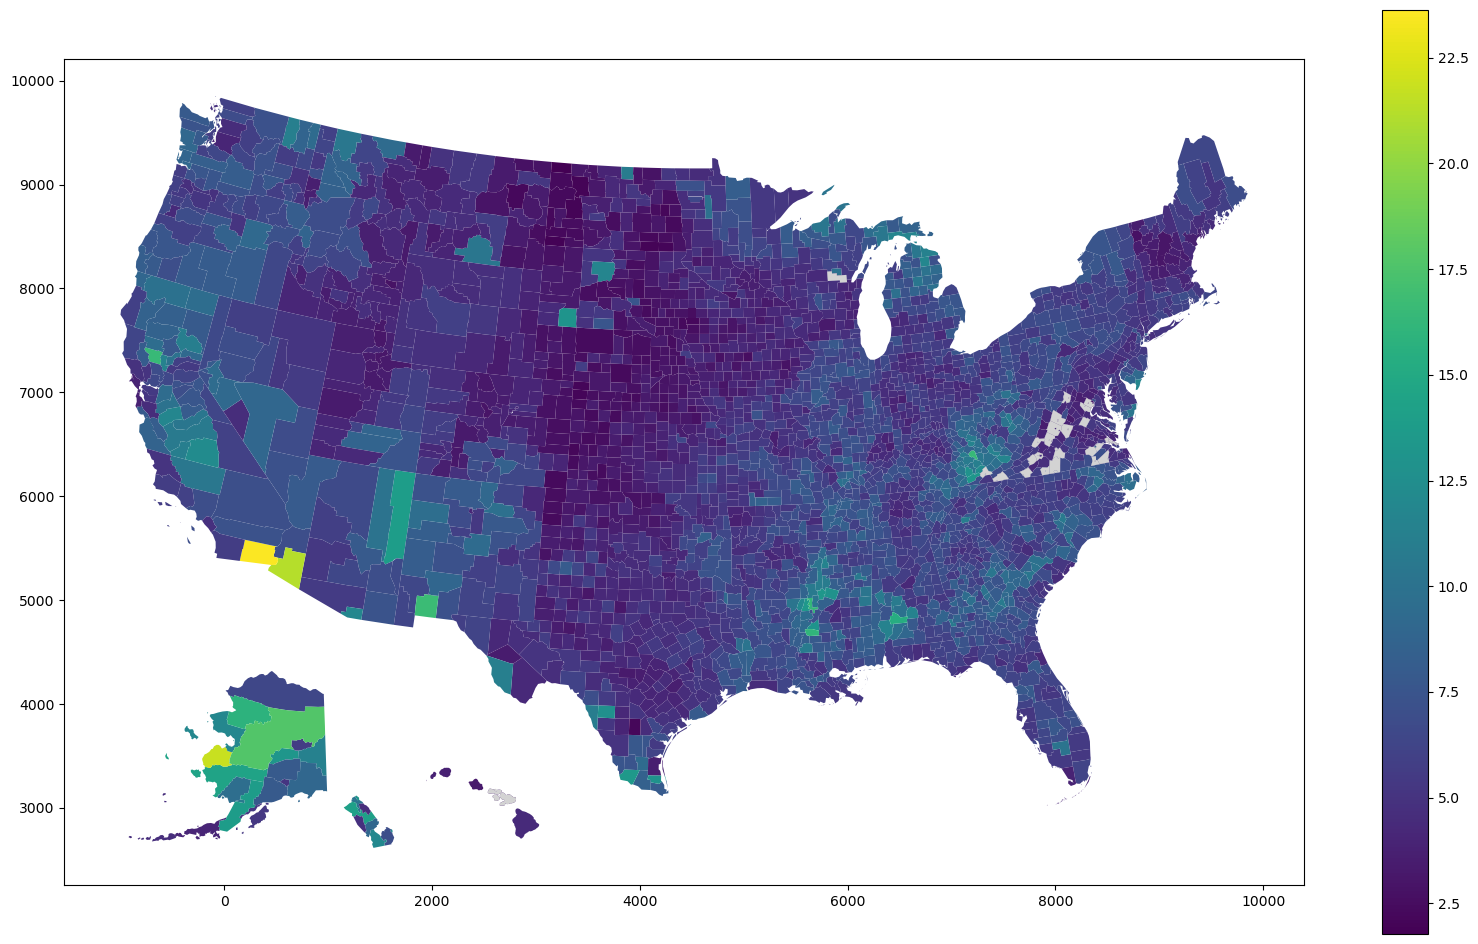

In [ ]:
test_db = gpd.GeoDataFrame(counties_db)
test_db.plot('unemp_rate', legend=True, figsize=(20,12), missing_kwds={'color': 'lightgray'})

### Récupération données nationales

In [ ]:
#Séries à l'échelle nationale :
#https://fred.stlouisfed.org/series/DSPGRX1A020NBEA : expenditures in ammunition + guns
#https://fred.stlouisfed.org/series/G160091A027NBEA : police expenditures

## Traitement de la base sur la législation par Etat

La base ici étudiée nous permet de synthétiser les différences de législation encadrant la vente, la possession et l'utilisation d'armes à feu sur le teritoire américain. Pour pouvoir comparer ces différences, nous essayons ici de construire des variables synthétiques traduisant l'intensité des restrictions dans plusieurs catégories : ....

La documentation de la base peut se trouver à l'addresse https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fmail.statefirearmlaws.org%2Fsites%2Fdefault%2Ffiles%2F2020-07%2Fcodebook_0.xlsx&wdOrigin=BROWSELINK.

In [165]:
legislation_db = pd.read_excel('data/gun_legislation.xlsx')
legislation_db = legislation_db.loc[legislation_db['year'] == 2018].sort_values(by='state')
legislation_db.head(10)

,state,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
27,Alabama,2018,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
57,Alaska,2018,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
87,Arizona,2018,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8
117,Arkansas,2018,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
147,California,2018,1,1,0,1,0,0,1,1,...,1,1,1,1,1,1,1,1,1,109
177,Colorado,2018,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,30
207,Connecticut,2018,1,1,1,1,1,0,0,1,...,1,1,1,1,1,1,1,0,1,88
237,Delaware,2018,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,41
267,Florida,2018,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
297,Georgia,2018,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


Ici, pour synthétiser l'information, nous pouvons construire un score d'intensité de la régulation pour chaque indicatrice, et calculer le score total pour cahque état (en groupant les indicatrices par type de législation).
Les scores sont ici fixés de manière arbitraire, se rangeant de 1(législation modérée) à 5(législation très restrictive). Nous calculons ensuite le maximum de score pour chaque catégorie de législation :
- réglementation des vendeurs
- réglementation des acheteurs
- restriction des armes à haut risque
- *background checks*
- réglementation de la possession d'armes à feu
- réglementation des armes d'assaut
- protetion des enfants
- réglementation du traffic d'armes
- restrictions après des faits de violence domestique


In [166]:
# Adjusted scores for each category
category_scores = {
    'dealer_regulations': {
        'dealer': 5,
        'dealerh': 4,
        'recordsdealer': 3,
        'recordsdealerh': 3,
        'recordsall': 2,
        'recordsallh': 2,
        'reportdealer': 5,
        'reportdealerh': 4,
        'reportall': 3,
        'reportallh': 3,
        'purge': 2,
        'residential': 1,
        'theft': 3,
        'security': 4,
        'inspection': 3,
        'liability': 4,
        'junkgun': 5,
    },
    'buyers_regulations': {
        'waiting': 4,
        'waitingh': 3,
        'permit': 5,
        'permith': 4,
        'permitlaw': 3,
        'fingerprint': 4,
        'training': 3,
        'registration': 5,
        'registrationh': 4,
        'defactoreg': 3,
        'defactoregh': 3,
        'age21handgunsale': 4,
        'age18longgunsale': 3,
        'age21longgunsaled': 4,
        'age21longgunsale': 4,
        'loststolen': 3,
        'onepermonth': 2,
    },
    'high_risk_gun': {
        'felony': 5,
        'violent': 4,
        'violenth': 4,
        'violentpartial': 3,
        'invcommitment': 5,
        'invoutpatient': 4,
        'danger': 4,
        'drugmisdemeanor': 3,
        'alctreatment': 3,
        'alcoholism': 3,
        'relinquishment': 4,
    },
    'background_checks': {
        'universal': 5,
        'universalh': 4,
        'gunshow': 4,
        'gunshowh': 3,
        'universalpermit': 5,
        'universalpermith': 4,
        'backgroundpurge': 2,
        'threedaylimit': 3,
        'mentalhealth': 4,
        'statechecks': 4,
        'statechecksh': 3,
    },
    'possession_regulations': {
        'age21handgunpossess': 5,
        'age18longgunpossess': 4,
        'age21longgunpossess': 5,
        'gvro': 5,
        'gvrolawenforcement': 4,
        'college': 4,
        'collegeconcealed': 3,
        'elementary': 4,
        'opencarryh': 3,
        'opencarryl': 3,
        'opencarrypermith': 4,
        'opencarrypermitl': 4,
    },
    'assault_weapons': {
        'assault': 5,
        'onefeature': 4,
        'assaultlist': 4,
        'assaultregister': 3,
        'assaulttransfer': 3,
        'magazine': 4,
        'tenroundlimit': 3,
        'magazinepreowned': 3,
    },
    'child_access': {
        'lockd': 4,
        'lockp': 3,
        'lockstandards': 3,
        'locked': 4,
        'capliability': 5,
        'capaccess': 4,
        'capuses': 4,
        'capunloaded': 3,
        'cap18': 4,
        'cap16': 4,
        'cap14': 5,
    },
    'gun_trafficking': {
        'traffickingbackground': 4,
        'traffickingprohibited': 5,
        'traffickingprohibitedh': 4,
        'strawpurchase': 5,
        'strawpurchaseh': 4,
        'microstamp': 4,
        'personalized': 3,
    },
    'domestic_violence': {
        'mcdv': 5,
        'mcdvdating': 5,
        'mcdvsurrender': 4,
        'mcdvsurrendernoconditions': 5,
        'mcdvsurrenderdating': 4,
        'mcdvremovalallowed': 3,
        'mcdvremovalrequired': 4,
        'incidentremoval': 3,
        'incidentall': 4,
        'dvro': 5,
        'dvrodating': 4,
        'exparte': 5,
        'expartedating': 4,
        'dvrosurrender': 4,
        'dvrosurrendernoconditions': 5,
        'dvrosurrenderdating': 4,
        'expartesurrender': 4,
        'expartesurrendernoconditions': 5,
        'expartesurrenderdating': 4,
        'dvroremoval': 4,
        'stalking': 4,
    },
    'concealed_carry' : {
    'permitconcealed': 5,
    'mayissue': 3,
    'showing': 4,
    'ccrevoke': 3,
    'ccbackground': 4,
    'ccbackgroundnics': 4,
    'ccrenewbackground': 3,
}
}

In [167]:
# Applying the adjusted scoring system
for category, indicator_scores in category_scores.items():
    legislation_db[f'{category}_score'] = legislation_db.apply(
        lambda row: max(row[indicator] * score for indicator, score in indicator_scores.items()),
        axis=1
    )


In [168]:
cols = ['state', 'year', 'lawtotal'] + [f'{category}_score' for category in category_scores.keys()]
legislation_db = legislation_db[cols]
legislation_db.sample(5)

,state,year,lawtotal,dealer_regulations_score,buyers_regulations_score,high_risk_gun_score,background_checks_score,possession_regulations_score,assault_weapons_score,child_access_score,gun_trafficking_score,domestic_violence_score,concealed_carry_score
1437,West Virginia,2018,18,4,4,5,0,0,0,0,0,5,0
447,Iowa,2018,24,0,4,5,4,5,0,5,0,5,5
1137,Pennsylvania,2018,37,5,3,5,4,4,0,4,4,5,5
507,Kentucky,2018,7,0,0,5,0,4,0,0,0,0,5
717,Mississippi,2018,2,0,0,5,0,4,0,0,0,0,0


In [161]:
score_columns = [f'{category}_score' for category in category_scores.keys()]
legislation_db['score_sum'] = legislation_db[score_columns].sum(axis=1)
legislation_db.sample(5)

,state,year,lawtotal,dealer_regulations_score,buyers_regulations_score,high_risk_gun_score,background_checks_score,possession_regulations_score,assault_weapons_score,child_access_score,gun_trafficking_score,domestic_violence_score,concealed_carry_score,score_sum
1017,North Dakota,2018,10,0,0,5,0,4,0,0,5,0,0,14
357,Idaho,2018,1,0,0,0,0,4,0,0,0,0,0,4
207,Connecticut,2018,88,5,5,5,5,5,5,5,5,5,5,50
267,Florida,2018,30,3,4,5,3,4,0,5,5,5,5,39
1317,Utah,2018,15,0,0,5,0,4,0,0,5,5,5,24


In [162]:
category_weights = {
    'dealer_regulations': 0.2,
    'buyers_regulations': 0.15,
    'high_risk_gun': 0.1,
    'background_checks': 0.1,
    'possession_regulations': 0.1,
    'assault_weapons': 0.1,
    'child_access': 0.05,
    'gun_trafficking': 0.05,
    'domestic_violence': 0.1,
    'concealed_carry': 0.15,  # Adjusted weight for concealed carry
}

# Calculate the weighted sum for each row
legislation_db['Weighted_Sum'] = 0
for category, weight in category_weights.items():
    legislation_db['Weighted_Sum'] += legislation_db[f'{category}_score'] * weight

<Axes: >

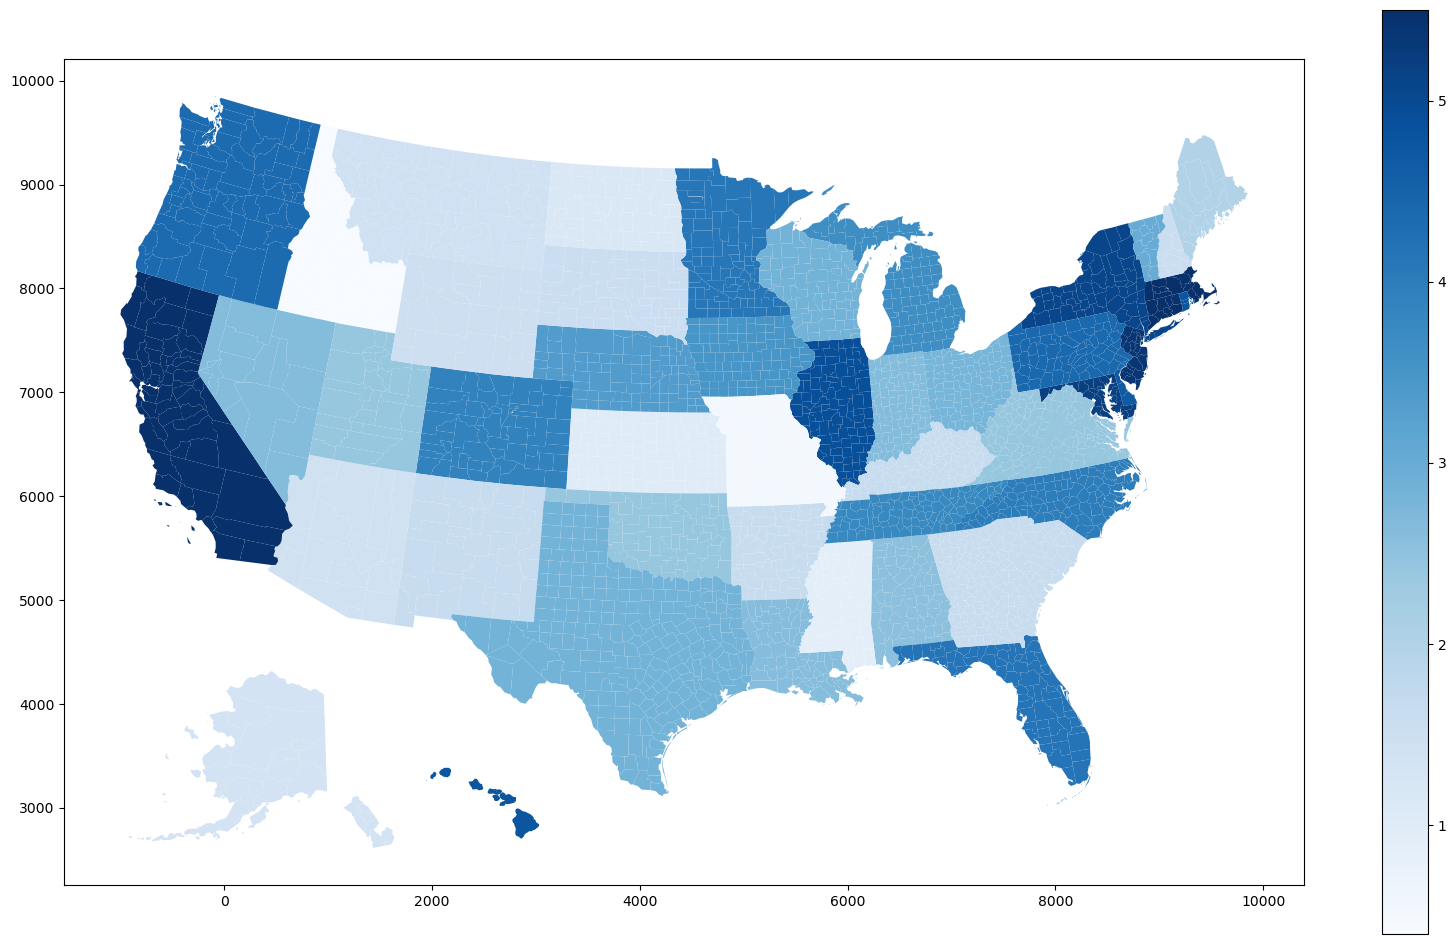

In [163]:
geom_legis_db = pd.merge(left=counties_db, right=legislation_db, right_on='state', left_on='Etat').drop(columns=['state', 'year'])
geom_legis_db = gpd.GeoDataFrame(geom_legis_db)
geom_legis_db.plot('Weighted_Sum', cmap='Blues', legend=True, figsize=(20,12))

In [169]:
geom_legis_db.loc[geom_legis_db['Etat'] == 'Florida']

,Nom,Etat,Code_Etat,id_Etat,id_county,fips,geometry,lawtotal,dealer_regulations_score,buyers_regulations_score,high_risk_gun_score,background_checks_score,possession_regulations_score,assault_weapons_score,child_access_score,gun_trafficking_score,domestic_violence_score,concealed_carry_score,score_sum,Weighted_Sum
324,Alachua,Florida,FL,27291,27660,12001,"POLYGON ((7731.000 4374.000, 7733.000 4362.000...",30,3,4,5,3,4,0,5,5,5,5,39,4.15
325,Baker,Florida,FL,27291,27661,12003,"POLYGON ((7715.000 4485.000, 7704.000 4483.000...",30,3,4,5,3,4,0,5,5,5,5,39,4.15
326,Bay,Florida,FL,27291,27662,12005,"MULTIPOLYGON (((6950.000 4493.000, 6953.000 44...",30,3,4,5,3,4,0,5,5,5,5,39,4.15
327,Bradford,Florida,FL,27291,27663,12007,"POLYGON ((7732.000 4375.000, 7731.000 4374.000...",30,3,4,5,3,4,0,5,5,5,5,39,4.15
328,Brevard,Florida,FL,27291,27664,12009,"MULTIPOLYGON (((8108.000 4130.000, 8103.000 40...",30,3,4,5,3,4,0,5,5,5,5,39,4.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,Union,Florida,FL,27291,27722,12125,"POLYGON ((7694.000 4481.000, 7665.000 4427.000...",30,3,4,5,3,4,0,5,5,5,5,39,4.15
387,Volusia,Florida,FL,27291,27723,12127,"POLYGON ((8020.000 4127.000, 7984.000 4178.000...",30,3,4,5,3,4,0,5,5,5,5,39,4.15
388,Wakulla,Florida,FL,27291,27724,12129,"MULTIPOLYGON (((7177.000 4368.000, 7179.000 43...",30,3,4,5,3,4,0,5,5,5,5,39,4.15
389,Walton,Florida,FL,27291,27725,12131,"POLYGON ((6726.000 4425.000, 6743.000 4435.000...",30,3,4,5,3,4,0,5,5,5,5,39,4.15


### Récupération du nombre d'armes vendues chaque année par Etat

Pas de données publiques, le proxy le plus fréquent est le nombre de background checks : https://github.com/BuzzFeedNews/nics-firearm-background-checks/tree/master




In [ ]:
bg_checks_db = pd.read_csv('data/bg_checks.csv')
bg_checks_db = bg_checks_db[['month', 'state', 'totals']]
bg_checks_db.sample(5)

,month,state,totals
8828,2010-05,Montana,7361
13323,2003-07,Idaho,4844
8162,2011-05,Maryland,6920
2916,2019-04,Alaska,6505
6565,2013-10,Maine,9707


In [ ]:
# Assuming 'month' is a string in 'year-month' format
# If not, convert it to datetime using pd.to_datetime(bg_checks_db['month'])
bg_checks_db['month'] = pd.to_datetime(bg_checks_db['month'] + '-01')

# Create a new column for the year
bg_checks_db['year'] = bg_checks_db['month'].dt.year

# Create a pivot table
bg_checks_db = bg_checks_db.pivot_table(values='totals', index='state', columns='year', aggfunc='sum', fill_value=0)

# Display the result
bg_checks_db = bg_checks_db.loc[:, 2013:2018]
bg_checks_db.reset_index(inplace=True)

In [ ]:
bg_checks_db

year,state,2013,2014,2015,2016,2017,2018
0,Alabama,563880,621305,737509,616947,477345,474294
1,Alaska,93405,87623,85621,87647,80839,78761
2,Arizona,363036,310672,331442,416279,384930,377838
3,Arkansas,279736,234282,257346,266014,237629,248439
4,California,1368295,1474616,1761079,2377167,1570110,1297132
5,Colorado,514658,413284,454062,540514,496995,524770
6,Connecticut,294338,270297,307750,317692,181779,177690
7,Delaware,40062,42950,50416,59430,50639,47723
8,District of Columbia,497,512,742,875,1540,3244
9,Florida,1073859,1034546,1147082,1435340,1276549,1203145
